Look at object detection rate weighed by topic

In [7]:
from src.features.videos.objects import object as object_helper
from src.models.lda import lda as lda_helper
from src import constants
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np

import psycopg2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Get the detected objects and the topics
object_occurence_rate = object_helper.divide_by_duration(object_helper.get_occurence_sum())
object_occurence_rate.head()
features_connection = psycopg2.connect(database="video_article_retrieval", user="postgres")
average_topics = pd.read_sql("SELECT * FROM average_topics", con=features_connection)

In [9]:
# Merge average topics and detected objects
data = pd.merge(average_topics, object_occurence_rate,  how='right', left_on=['id','platform'], right_on = ['id','platform'])
data.head()

,id,platform,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,...,sink,refrigerator,book,clock,vase,scissors,teddy_bear,hair_drier,toothbrush,duration
0,wsbtv/10157004889480695,facebook,0.000000,0.653323,0.0,0.000,0.022118,0.000000,0.125464,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,236288
1,KHOU11/10157855122244062,facebook,0.002818,0.927415,0.0,0.000,0.000000,0.043440,0.005280,0.018187,...,0.0,0.000000,0.000000,0.000208,0.0,0.0,0.0,0.0,0.0,729216
2,100013660111371/486703935128273,facebook,0.000000,0.629809,0.0,0.051,0.211798,0.093693,0.012093,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,779904
3,1488021131510328/1994413240871112,facebook,0.000000,0.453624,0.0,0.000,0.000000,0.132679,0.366747,0.040566,...,0.0,0.000004,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,268051
4,ABC15/10155973576596359,facebook,0.000000,0.000000,0.0,0.000,0.000000,0.223820,0.428964,0.259963,...,0.0,0.000000,0.000054,0.000000,0.0,0.0,0.0,0.0,0.0,74153


In [24]:
from collections import defaultdict
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.3f}'.format

topic_objects = defaultdict(lambda: defaultdict(int))

topics = lda_helper.get_topic_columns(10)
objects = [label.replace(" ", "_") for label in constants.COCO_CLASS_NAMES]

from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

for label in objects:
    for topic in topics:
        topic_objects[label][topic] = sum(data[label] * data[topic])

df = pd.DataFrame(topic_objects)
df = df.apply(lambda x: x/x.max(), axis=0)

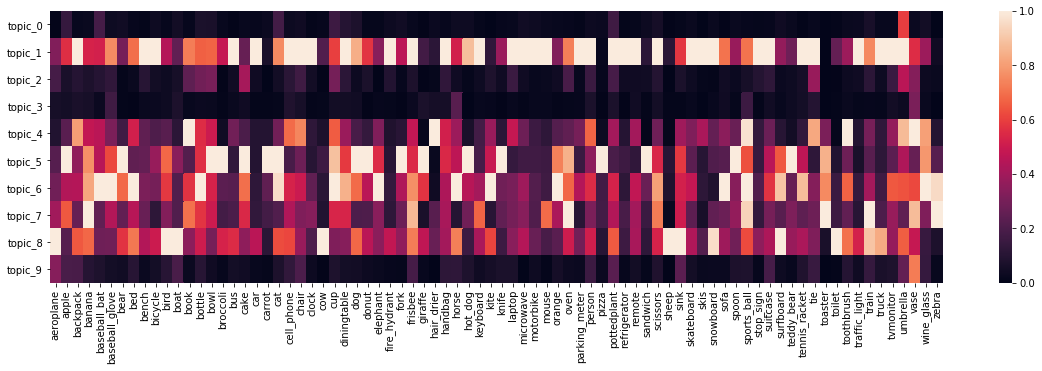

In [16]:
import seaborn

fig, ax = plt.subplots(figsize=(20,5))
seaborn.heatmap(ax=ax, data=df)
pyplot.savefig("topic_objects_heatmap.pdf")
plt.show()

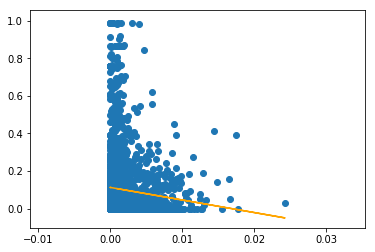

In [53]:
import random

# Make predictions using the testing set
x_col = "person" # random.choice(objects)
y_col = "topic_7" # random.choice(topics)

plt.scatter(data[x_col], data[y_col])

from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(data[[x_col]].values, data[[y_col]])
plt.plot(data[x_col], regr.predict(data[[x_col]]), color='orange')

plt.show()

In [58]:
# TODO plot density distributions of a single object for every topic
label = "person"
for topic in topics:
    topic_prevalence = data[label] * data[topic] / sum(data[topic])
    print("%s:\t%.5f (+/- %.4f)" % (topic, np.mean(normalized_topic_prevalence), np.std(data[label] * data[topic])))

topic_0:	0.07431 (+/- 0.0001)
topic_1:	0.07850 (+/- 0.0009)
topic_2:	0.10564 (+/- 0.0004)
topic_3:	0.13206 (+/- 0.0002)
topic_4:	0.11110 (+/- 0.0009)
topic_5:	0.08777 (+/- 0.0006)
topic_6:	0.08304 (+/- 0.0006)
topic_7:	0.06830 (+/- 0.0004)
topic_8:	0.06571 (+/- 0.0006)
topic_9:	0.10677 (+/- 0.0004)
